<a href="https://colab.research.google.com/github/gianellannie/telecom-x-parte2/blob/main/TelecomX_LATAM_parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# **1. Preparación de los Datos**

In [59]:
datos = pd.read_csv('/content/datos_tratados.csv')
datos.head()

,churn,genero,adulto_mayor,pareja,dependientes,meses_contrato,servicio_telefonico,multiples_lineas,servicio_internet,seguridad_en_linea,...,proteccion_dispositivo,soporte_tecnico,tv_streaming,peliculas_streaming,tipo_contrato,facturacion_electronica,metodo_pago,cargo_mensual,cargo_total,cargo_diario
0,no,femenino,no,si,si,9,si,no,dsl,no,...,no,si,si,no,anual,si,cheque por correo,65.6,593.30,2.186667
1,no,masculino,no,no,no,9,si,si,dsl,no,...,no,no,no,si,mensual,no,cheque por correo,59.9,542.40,1.996667
2,si,masculino,no,no,no,4,si,no,fibra optica,no,...,si,no,no,no,mensual,si,cheque electronico,73.9,280.85,2.463333
3,si,masculino,si,si,no,13,si,no,fibra optica,no,...,si,no,si,si,mensual,si,cheque electronico,98.0,1237.85,3.266667
4,si,femenino,si,si,no,3,si,no,fibra optica,no,...,no,si,si,no,mensual,si,cheque por correo,83.9,267.40,2.796667


In [60]:
X = datos.drop(columns=['churn'])
y = datos['churn']

In [61]:
codificacion = make_column_transformer(
    (OneHotEncoder(drop='first'), ['genero', 'adulto_mayor', 'pareja', 'dependientes', 'servicio_telefonico', 'multiples_lineas', 'servicio_internet',
                                       'seguridad_en_linea', 'respaldo_en_linea', 'proteccion_dispositivo', 'soporte_tecnico', 'tv_streaming',
                                       'peliculas_streaming', 'tipo_contrato', 'facturacion_electronica', 'metodo_pago']),
    remainder='passthrough',
    force_int_remainder_cols=False,
    sparse_threshold=0
)
X_codificado = codificacion.fit_transform(X)
X_codificado = pd.DataFrame(X_codificado, columns=codificacion.get_feature_names_out(X.columns))
X_codificado.head()

,onehotencoder__genero_masculino,onehotencoder__adulto_mayor_si,onehotencoder__pareja_si,onehotencoder__dependientes_si,onehotencoder__servicio_telefonico_si,onehotencoder__multiples_lineas_si,onehotencoder__multiples_lineas_sin servicio telefonico,onehotencoder__servicio_internet_fibra optica,onehotencoder__servicio_internet_no,onehotencoder__seguridad_en_linea_si,...,onehotencoder__tipo_contrato_dos años,onehotencoder__tipo_contrato_mensual,onehotencoder__facturacion_electronica_si,onehotencoder__metodo_pago_cheque por correo,onehotencoder__metodo_pago_tarjeta de credito automatica,onehotencoder__metodo_pago_transferencia bancaria automatica,remainder__meses_contrato,remainder__cargo_mensual,remainder__cargo_total,remainder__cargo_diario
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,9.0,65.6,593.30,2.186667
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,9.0,59.9,542.40,1.996667
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,4.0,73.9,280.85,2.463333
3,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,13.0,98.0,1237.85,3.266667
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,3.0,83.9,267.40,2.796667


In [62]:
le = LabelEncoder()
y_codificado = le.fit_transform(y)
y_codificado = pd.Series(y_codificado, name='churn')
y_codificado.head()

,churn
0,0
1,0
2,1
3,1
4,1


# **2. Correlación y Selección de Variables**

In [63]:
datos_preparados = X_codificado.copy()
datos_preparados['churn'] = y_codificado

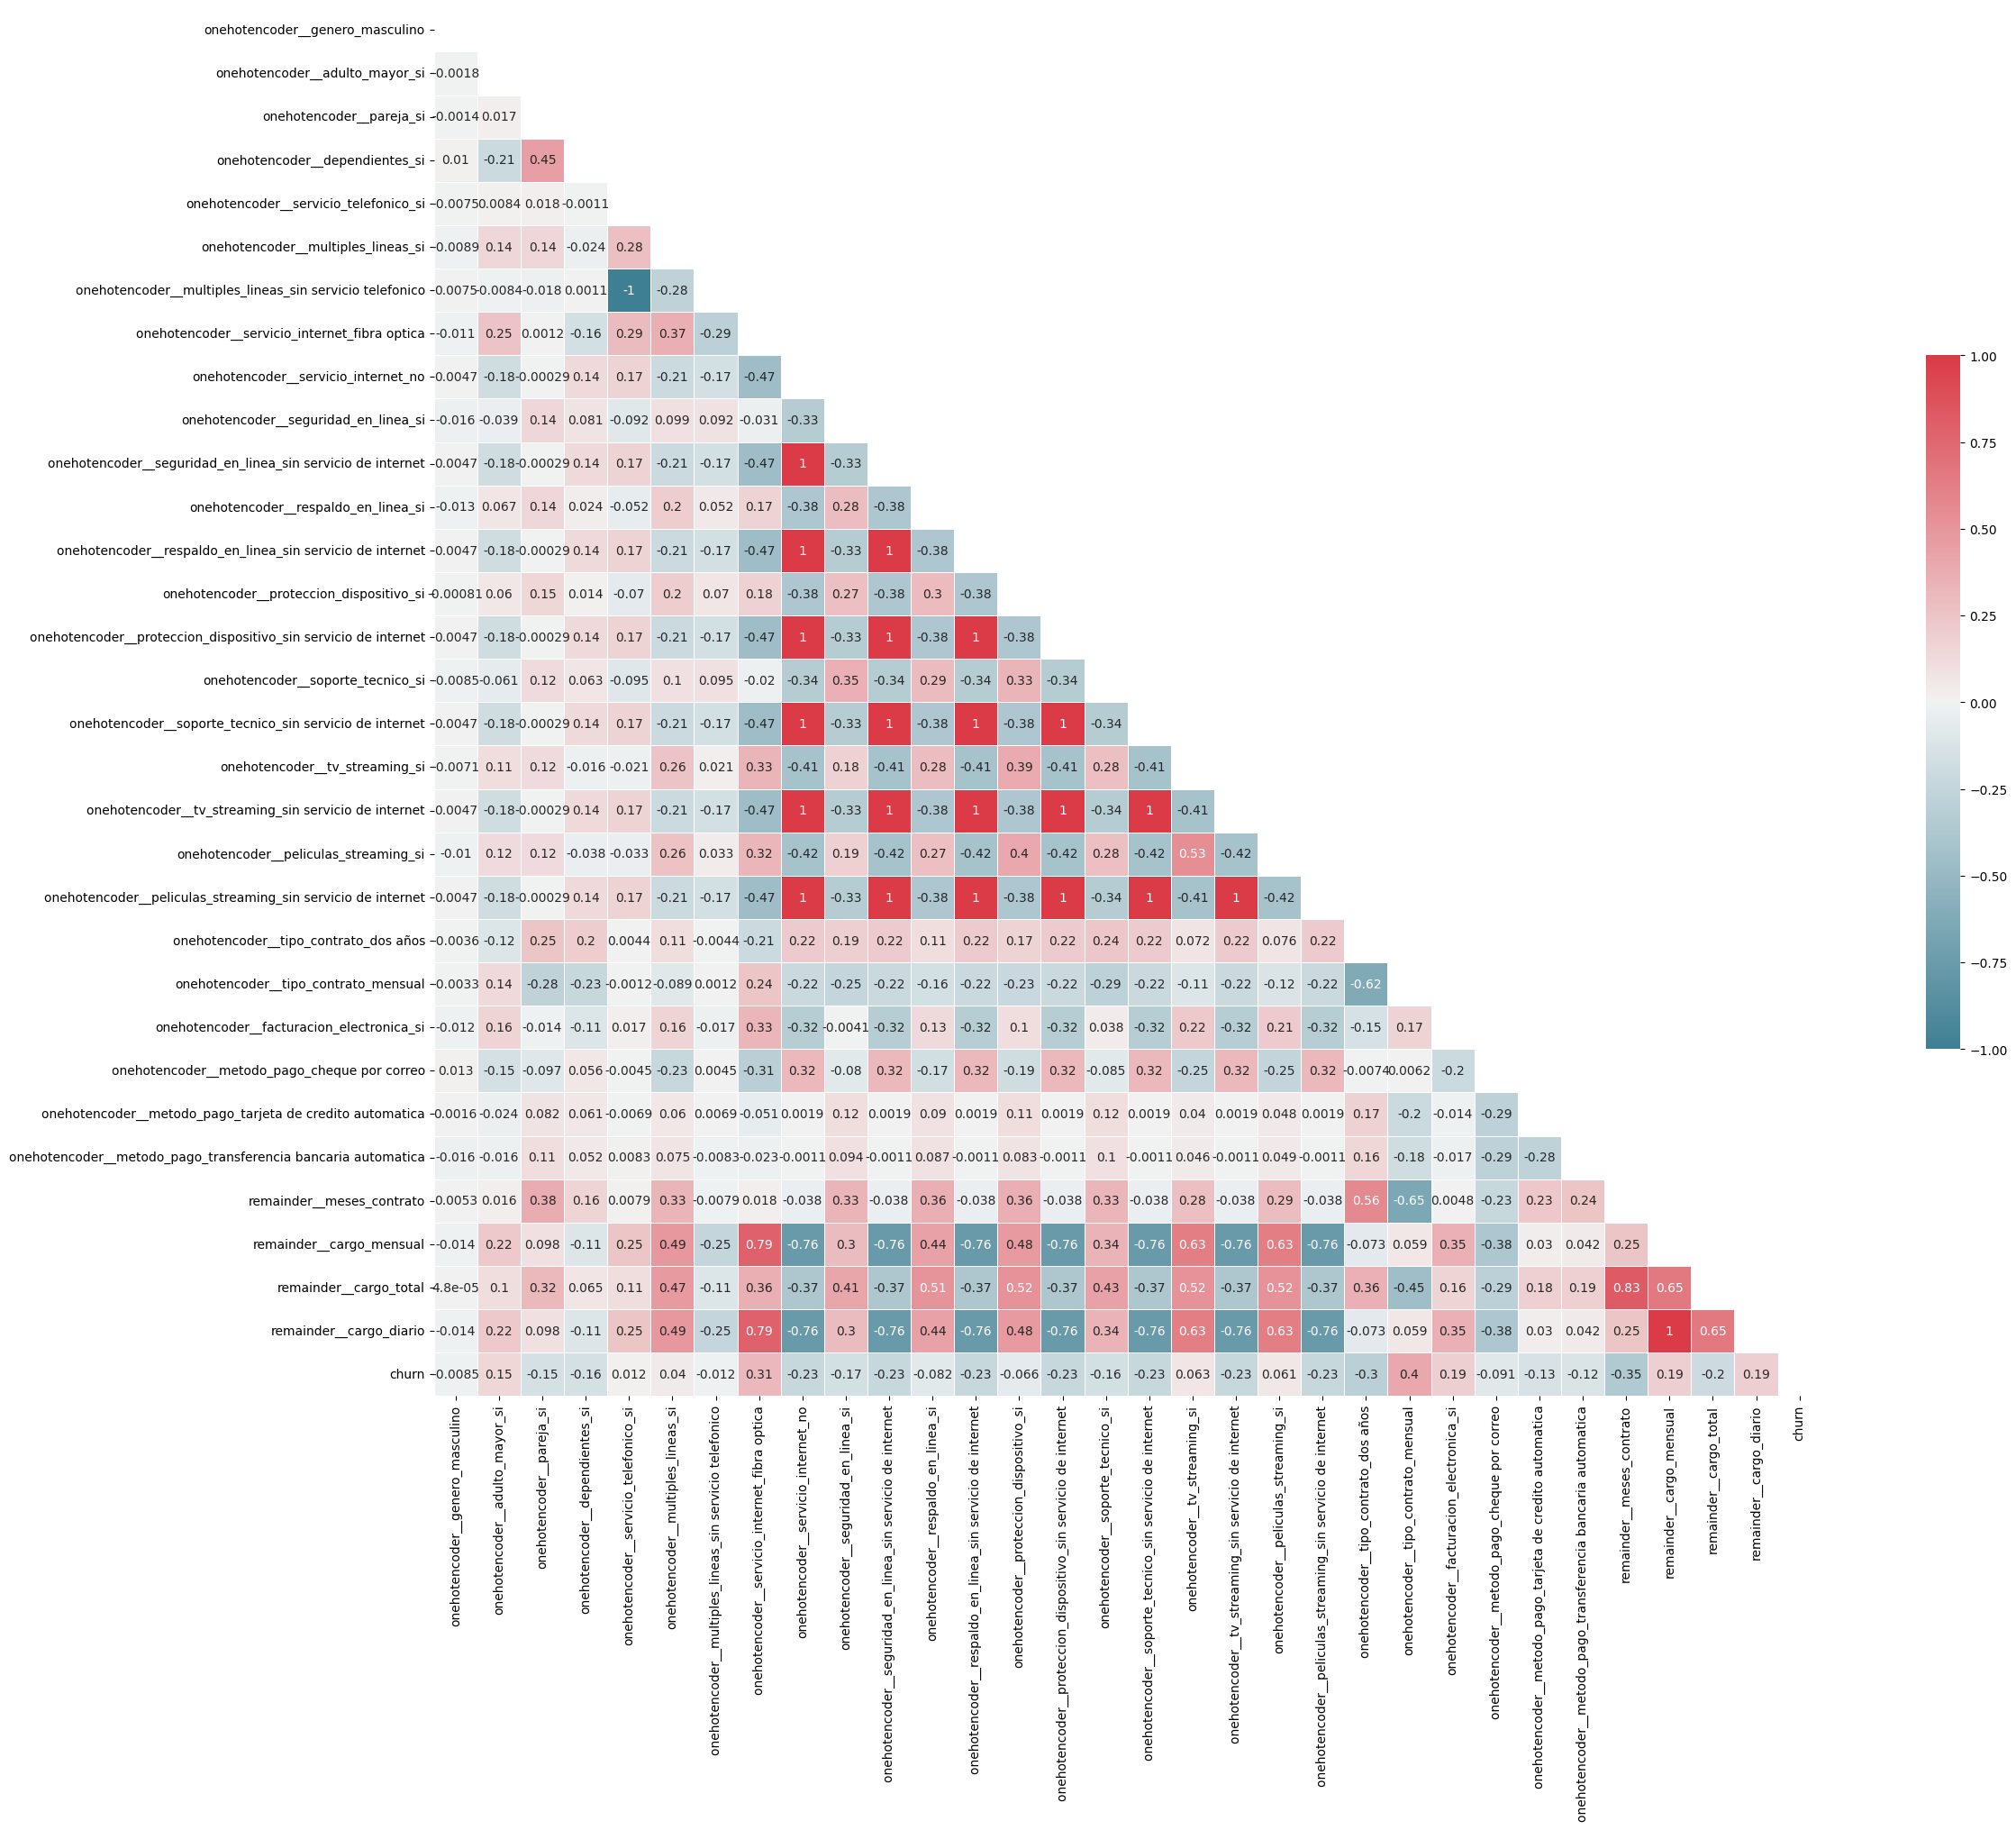

In [64]:
corr = datos_preparados.corr()

mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

fig, ax = plt.subplots(figsize=(30, 20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mascara, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

plt.show()

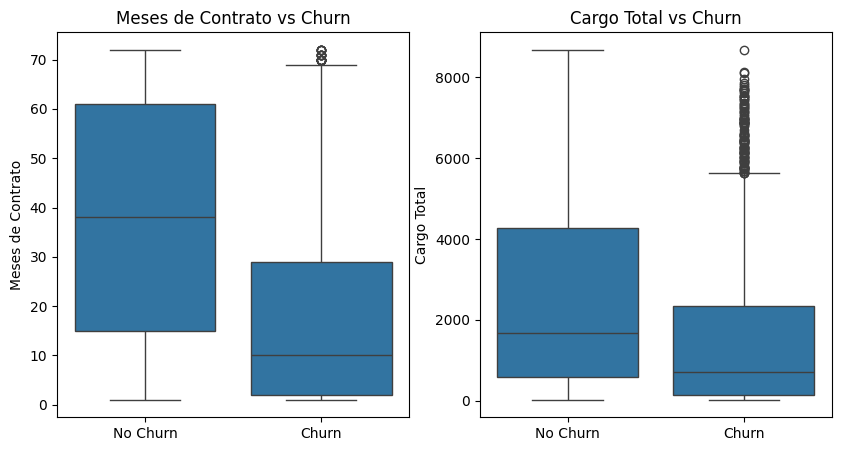

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x='churn', y='remainder__meses_contrato', data=datos_preparados, ax=ax[0])
ax[0].set_title('Meses de Contrato vs Churn')
ax[0].set_xlabel('')
ax[0].set_ylabel('Meses de Contrato')
ax[0].set_xticks(np.arange(2),['No Churn', 'Churn'])

sns.boxplot(x='churn', y='remainder__cargo_total', data=datos_preparados, ax=ax[1])
ax[1].set_title('Cargo Total vs Churn')
ax[1].set_xlabel('')
ax[1].set_ylabel('Cargo Total')
ax[1].set_xticks(np.arange(2),['No Churn', 'Churn'])

plt.show()

# **3. Modelado Predictivo**

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_codificado, y_codificado, test_size=0.3, stratify=y_codificado, random_state=10)

In [67]:
smote = SMOTE(random_state=10)
X_train_balanceado, y_train_balanceado = smote.fit_resample(X_train, y_train)

In [68]:
normalizacion = MinMaxScaler()
X_train_normalizado = normalizacion.fit_transform(X_train_balanceado)
X_train_normalizado = pd.DataFrame(X_train_normalizado, columns=X_train.columns)

X_test_normalizado = normalizacion.transform(X_test)
X_test_normalizado = pd.DataFrame(X_test_normalizado, columns=X_test.columns)

In [69]:
modelo_rfc = RandomForestClassifier(max_depth=10, random_state=10, class_weight='balanced')
modelo_rfc.fit(X_train_balanceado, y_train_balanceado)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=10)

In [70]:
modelo_lr = LogisticRegression(random_state=10, class_weight='balanced')
modelo_lr.fit(X_train_normalizado, y_train_balanceado)

LogisticRegression(class_weight='balanced', random_state=10)

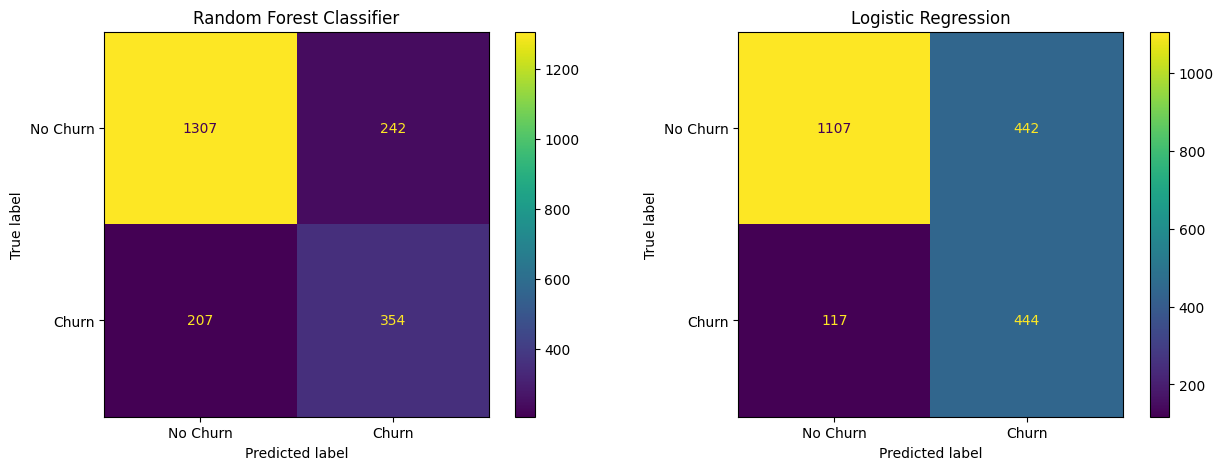

In [79]:
def matriz_confusion_modelos():
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  cm_rfc = confusion_matrix(y_test, modelo_rfc.predict(X_test))
  cmd_rfc = ConfusionMatrixDisplay(cm_rfc, display_labels=['No Churn', 'Churn'])
  ax[0].set_title('Random Forest Classifier')
  cmd_rfc.plot(ax=ax[0]);

  cm_lr = confusion_matrix(y_test, modelo_lr.predict(X_test_normalizado))
  cmd_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['No Churn', 'Churn'])
  ax[1].set_title('Logistic Regression')
  cmd_lr.plot(ax=ax[1]);

  plt.show()

matriz_confusion_modelos()

In [72]:
print('************** Random Forest Classifier **************')
print(classification_report(y_test, modelo_rfc.predict(X_test)))
print('\n*********** Logistic Regression ***********')
print(classification_report(y_test, modelo_lr.predict(X_test_normalizado)))

************** Random Forest Classifier **************
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1549
           1       0.59      0.63      0.61       561

    accuracy                           0.79      2110
   macro avg       0.73      0.74      0.73      2110
weighted avg       0.79      0.79      0.79      2110


*********** Logistic Regression ***********
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1549
           1       0.50      0.79      0.61       561

    accuracy                           0.74      2110
   macro avg       0.70      0.75      0.71      2110
weighted avg       0.80      0.74      0.75      2110



# **4.Interpretación y Conclusiones**

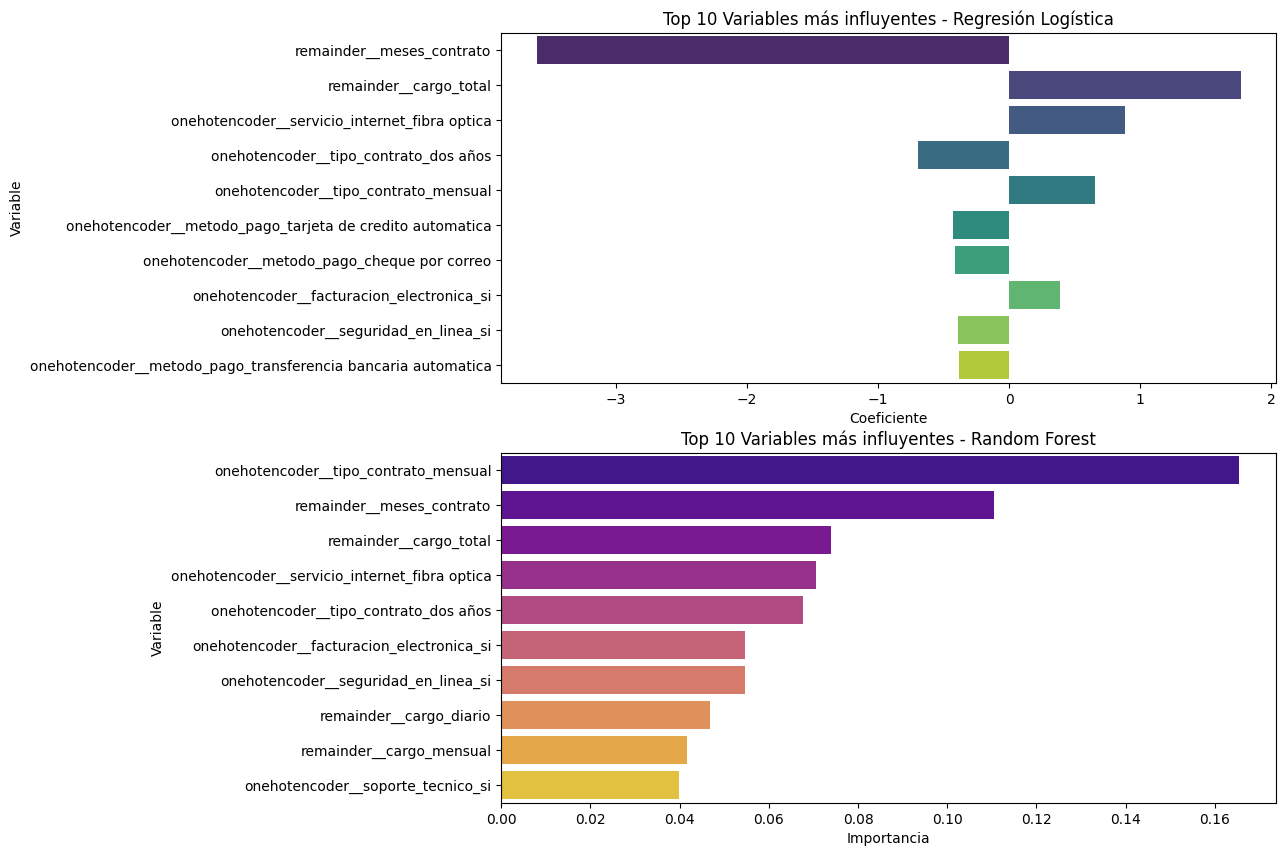

In [57]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

importancias_rf = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": modelo_rfc.feature_importances_
})
importancias_rf = importancias_rf.sort_values(by="Importancia", ascending=False)

sns.barplot(data=importancias_rf.head(10), x="Importancia", y="Variable", palette="plasma", ax=ax[1])
ax[1].set_title("Top 10 Variables más influyentes - Random Forest")
ax[1].set_xlabel("Importancia")
ax[1].set_ylabel("Variable")

coeficientes = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": modelo_lr.coef_[0]
})
coeficientes["Importancia_Abs"] = coeficientes["Coeficiente"].abs()
coeficientes = coeficientes.sort_values(by="Importancia_Abs", ascending=False)

sns.barplot(data=coeficientes.head(10), x="Coeficiente", y="Variable", palette="viridis", ax=ax[0])
ax[0].set_title("Top 10 Variables más influyentes - Regresión Logística")
ax[0].set_xlabel("Coeficiente")
ax[0].set_ylabel("Variable")

plt.show()

## Informe

---


### 1) Resumen

**Objetivo:** identificar los factores que más influyen en la cancelación (churn) y evaluar el desempeño de los modelos entrenados para priorizar acciones de retención.

**Modelos evaluados:** Random Forest (RF) y Regresión Logística (LR) con tratamiento de desbalance usando **SMOTE**, codificación **One‑Hot** y **normalizado MinMax**.

**Hallazgos clave:**

* **RF obtiene mejor desempeño global** (accuracy 0.79 y F1 ponderado 0.79).
* **LR detecta mejor a los que cancelan** (recall de *Churn* 0.79 vs. 0.63 en RF), a costa de más falsos positivos (precisión en *Churn* 0.50 vs. 0.59 en RF).
* Los patrones más asociados a *Churn* en el EDA y la interpretación de modelos son: **tenure bajo (meses de contrato), cargos mensuales altos, contrato mes‑a‑mes, menor gasto acumulado (propio de clientes nuevos), y ausencia de servicios de soporte/seguridad**.
* **Estrategia recomendada:** ejecutar **campañas segmentadas** (onboarding temprano, conversión a contratos anuales, revisión de plan/precio y soporte proactivo).

### 2) Métricas y comparación de modelos


**Matriz de confusión**

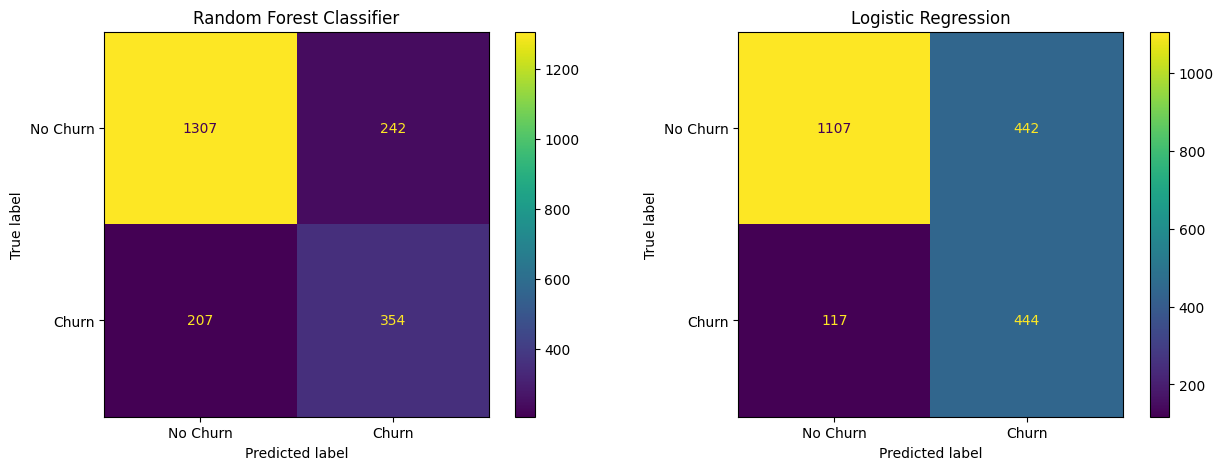

In [80]:
matriz_confusion_modelos()

**Métricas por clase (extraídas del *classification report*)**

| Modelo              | Accuracy | Recall (Churn=1) | Precision (Churn=1) | F1 (Churn=1) |
| ------------------- | -------: | ---------------: | ------------------: | -----------: |
| Random Forest       | **0.79** |             0.63 |            **0.59** |         0.61 |
| Logistic Regression |     0.74 |         **0.79** |                0.50 |     **0.61** |

**Lectura:**

* Si el objetivo es **minimizar falsos negativos** (no detectar a quien sí cancelará), **LR** es preferible.
* Si el objetivo es **maximizar exactitud global** o reducir contactos innecesarios, **RF** ofrece mejor trade‑off por defecto.
* En gestión de churn, suele priorizarse **recall** (evitar pérdidas), ajustando el **umbral** y el **presupuesto** para acotar falsos positivos.

### 3) Factores que más influyen en la cancelación


#### 3.1 Señales de **mayor riesgo de churn**

1. **Tenure bajo (meses de contrato)**
   Clientes nuevos (pocos meses) presentan mayor propensión a cancelar (curva de abandono temprano).
2. **Cargos mensuales altos** (*MonthlyCharges*)
   Percepción de tarifa elevada respecto al valor percibido; sensibilidad al precio.
3. **Contrato mes‑a‑mes** (*Month‑to‑month*)
   Alta flexibilidad → mayor probabilidad de salida.
4. **Menor cargo total acumulado** (*TotalCharges* bajo)
   Proxy de antigüedad/bajo compromiso; correlaciona con 1).
5. **Ausencia de servicios de valor** (p. ej., *TechSupport*, *OnlineSecurity*, *DeviceProtection* = No)
   Menor “stickiness” y menor barrera de salida.
6. **Métodos de pago manuales** (p. ej., *Electronic Check* si está disponible)
   Tienden a asociarse a mayor churn que *auto‑pay* (transferencia/TC).
   

#### 3.2 Señales de **menor riesgo de churn**

1. **Tenure alto** (clientes maduros)
2. **Contratos de 1–2 años**
3. **Bundles/servicios complementarios** (seguridad, soporte, paquetes)
4. **Pago automatizado** (débito/TC) y facturación estable

### 4) Recomendaciones de retención

#### 4.1 Activación temprana (clientes con **tenure < 3 meses**)

* **Programa de onboarding en 30‑60‑90 días:** contacto proactivo, tutoriales y check‑ins.
* **Paquetes de bienvenida**: descuentos temporales, upgrades limitados.
* **Alertas de uso/experiencia**: detectar baja utilización o incidencias y resolverlas rápido.

#### 4.2 Optimización de precio/plan (clientes con **cargos altos**)

* **Revisión de plan** con recomendador: ajustar velocidad/servicios al perfil de uso.
* **Descuentos por permanencia** o **bonos por fidelidad**.
* **Bundles** que eleven el valor percibido (p. ej., soporte avanzado + seguridad).

#### 4.3 Migración contractual (clientes **Month‑to‑month**)

* **Incentivos a contratos de 12/24 meses** (meses gratis, instalación/upgrade sin costo).
* **Cláusula de “pausa”** temporal antes de cancelar para evitar baja definitiva.

#### 4.4 Servicios de valor y soporte

* **Oferta proactiva de *TechSupport/OnlineSecurity*** a quienes aún no lo tienen.
* **Ticketing con SLA priorizado** para clientes en riesgo alto.
* **Encuestas NPS/CSAT** tras incidentes críticos.

#### 4.5 Pago y fricción operativa

* **Incentivar *auto‑pay*** (bono por domiciliación) y **factura digital**.
* **Recordatorios inteligentes** y *soft collections* para evitar cortes.

### Conclusión

El **riesgo de churn** está fuertemente ligado a **baja antigüedad**, **tarifas mensuales altas**, **contratos mensuales** y **menor adopción de servicios de valor**. Con un **modelo priorizando recall** y **campañas segmentadas** (onboarding temprano, optimización de plan/precio, migración contractual y soporte proactivo) es posible reducir la cancelación y maximizar el **CLV retenido**.